# BBC News Article Analysis and Summarization Project

## Project Overview
This project addresses the need of efficiently analyze and summarize textual information by developing a comprehensive document analysis and summarization system, specifically designed to process BBC news articles.

## Technical Implementation
Our system processes 500 BBC news articles across five categories, combining traditional text analysis with modern natural language processing capabilities. Using Python's ecosystem of text processing libraries (NLTK, pandas, WordCloud, and Hugging Face Transformers), the system performs statistical analysis, generates visualizations, and creates automated summaries. The workflow includes text preprocessing, calculation of various metrics (word/sentence counts, frequency distributions), word cloud generation, and text summarization using the BART model, with all results compiled into a comprehensive CSV file.

We start by setting up the foundation of our project by importing all necessary Python libraries. We utilize several key packages:
For text processing, we rely on the Natural Language Toolkit (`nltk`), which provides essential tools for tokenization (breaking text into words and sentences) and access to stopwords (common words like "the", "is", "at" that we often want to filter out). `pandas` is used for efficient data manipulation, especially when handling our CSV files of BBC news articles. The visualization aspect is handled by `WordCloud` for generating word frequency visualizations and `Matplotlib` for creating and displaying plots. Finally, we incorporate Hugging Face's `transformers` library, specifically using their pipeline functionality, to implement advanced text summarization features using pre-trained models.

In [1]:
# Import the required libraries

# Core data processing and analysis libraries
import pandas as pd  # For data manipulation and analysis
import random  # For random sampling operations

# Natural Language Processing tools
import nltk  # Main NLP toolkit
from nltk.tokenize import sent_tokenize, word_tokenize  # For text tokenization
from nltk.corpus import stopwords  # For removing common words

# Visualization libraries
from wordcloud import WordCloud  # For generating word clouds
import matplotlib.pyplot as plt  # For creating plots

# Data structure utilities
from collections import Counter  # For counting word frequencies

# Deep Learning libraries for text summarization
from transformers import pipeline  # For easy model implementation

We then download the essential resources from NLTK (Natural Language Toolkit) that our project requires. NLTK uses a modular approach where various language processing resources can be downloaded as needed, saving storage space. The `punkt` package contains a pre-trained model for sentence tokenization, which helps in breaking down text into individual sentences. The `stopwords` package provides lists of common words (like "the", "is", "at") in various languages that often don't carry significant meaning in text analysis. The `punkt_tab` package includes additional tokenization models that help improve the accuracy of text segmentation.

In [2]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sezinmumcu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sezinmumcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sezinmumcu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

We implement the `DocumentAnalyzer` class, which serves as the core engine of our text analysis system.

The class provides comprehensive text analysis capabilities through several methods:
- `__init__`: Initializes the analyzer with English stopwords and the BART summarization model from Facebook.
- `process_dataframe`: Handles bulk analysis of texts stored in a DataFrame, calculating the number of sentences and words, the average word and sentence lengths, the common words and phrases. It then applies these calculations to each row in the DataFrame.
- `basic_stats`: Provides fundamental text statistics for individual documents, including sentence count, word count, and average lengths.

Word Analysis Methods:
- `get_common_words`: Identifies the most frequent words, excluding stopwords
- `get_common_phrases`: Finds recurring multi-word expressions
- `create_wordcloud`: Generates visual representations of word frequencies

Advanced Processing:
- `generate_summary`: Creates concise summaries using the BART model
- `_split_into_chunks`: Helper method for handling long texts
- `save_analysis`: Exports results to CSV format

In [3]:
class DocumentAnalyzer:
    def __init__(self):
        """Initialize the DocumentAnalyzer with necessary resources."""
        self.stop_words = set(stopwords.words('english'))
        self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    def process_dataframe(self, df, text_column):
        """Process text data from a pandas DataFrame column."""
        df['num_sentences'] = df[text_column].apply(lambda x: len(sent_tokenize(x)))
        df['num_words'] = df[text_column].apply(lambda x: len(word_tokenize(x)))
        df['avg_word_length'] = df[text_column].apply(
            lambda x: sum(len(word) for word in word_tokenize(x)) / max(1, len(word_tokenize(x)))
        )
        df['avg_sentence_length'] = df[text_column].apply(
            lambda x: len(word_tokenize(x)) / max(1, len(sent_tokenize(x)))
        )
        df['common_words'] = df[text_column].apply(lambda x: self.get_common_words(x, n=10))
        df['common_phrases'] = df[text_column].apply(lambda x: self.get_common_phrases(x, n=5, phrase_length=2))
        return df

    def basic_stats(self, text):
        """Calculate basic text statistics for a single text string."""
        num_sentences = len(sent_tokenize(text))
        num_words = len(word_tokenize(text))
        avg_word_length = sum(len(word) for word in word_tokenize(text)) / max(1, num_words)
        avg_sentence_length = num_words / max(1, num_sentences)
        return {
            'num_sentences': num_sentences,
            'num_words': num_words,
            'avg_word_length': avg_word_length,
            'avg_sentence_length': avg_sentence_length
        }

    def get_common_words(self, text, n=10):
        """Find the n most common words in the text."""
        tokens = [word.lower() for word in word_tokenize(text) if word.isalpha()]
        filtered_tokens = [word for word in tokens if word not in self.stop_words]
        return Counter(filtered_tokens).most_common(n)

    def get_common_phrases(self, text, n=5, phrase_length=2):
        """Find the n most common phrases of specified length."""
        tokens = [word.lower() for word in word_tokenize(text) if word.isalpha()]
        phrases = nltk.ngrams(tokens, phrase_length)
        return Counter(phrases).most_common(n)

    def create_wordcloud(self, text, title=None):
        """Generate and display a word cloud visualization for the given text."""
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        if title:
            plt.title(title, fontsize=16)
        plt.axis('off')
        plt.show()

    def generate_summary(self, text, default_max_length=33, default_min_length=30):
        """
        Generate a summary using the BART model, dynamically adjusting summary length if needed.
        """
        chunks = self._split_into_chunks(text, max_chunk_size=1000)
        summaries = []

        for chunk in chunks:
            input_length = len(word_tokenize(chunk))
            max_length = min(default_max_length, max(10, input_length // 2))
            min_length = min(default_min_length, max(5, input_length // 4))

            try:
                summary = self.summarizer(
                    chunk,
                    max_length=max_length,
                    min_length=min_length,
                    do_sample=False
                )[0]['summary_text']
                summaries.append(summary)
            except Exception as e:
                print(f"Error summarizing chunk: {e}")
                summaries.append("Summary not available.")

        return " ".join(summaries)


    def _split_into_chunks(self, text, max_chunk_size=1000):
        """Helper method to split text into chunks for summarization."""
        return [text[i:i + max_chunk_size] for i in range(0, len(text), max_chunk_size)]

    def save_analysis(self, filepath, df):
        """Save analysis results to a CSV file."""
        try:
            df.to_csv(filepath, index=False)
            print(f"Analysis saved to: {filepath}")
        except Exception as e:
            print(f"Error saving file: {e}")

We now implement a comprehensive testing suite for the `DocumentAnalyzer` class. Our `run_tests()` function systematically checks all major functionalities of the DocumentAnalyzer class. It uses a controlled test environment with a predefined sample text that contains known patterns and characteristics.

The testing suite includes six distinct test cases:
- Basic Statistics Test: Verifies the analyzer's ability to compute fundamental text metrics
- Common Words Analysis: Tests the extraction and counting of frequently occurring words
- Common Phrases Analysis: Validates the identification of common multi-word expressions
- Text Summarization: Checks the text summarization functionality
- DataFrame Processing: Tests the analyzer's capability to process pandas DataFrames
- Word Cloud Generation: Verifies the visualization functionality

Each test is wrapped in a try-except block for robust error handling, providing clear feedback about success (✓) or failure (✗). The tests are designed to be independent, meaning a failure in one test won't prevent the execution of subsequent tests.

In [4]:
def run_tests():
    """Run tests for DocumentAnalyzer functionality"""
    print("Starting tests...\n")
    
    # Initialize analyzer
    analyzer = DocumentAnalyzer()
    
    # Sample test text
    test_text = """
    This is a test article for BBC news analysis. This article contains multiple sentences 
    and various words to test our document analyzer. We will use this sample to verify 
    different functions of our analyzer. The analyzer should process this text and provide 
    accurate statistics. It should also identify common words and phrases effectively.
    """
    
    # Test 1: Basic Stats
    print("Test 1: Basic Statistics")
    try:
        stats = analyzer.basic_stats(test_text)
        print("✓ Basic stats:", stats)
    except Exception as e:
        print("✗ Basic stats test failed:", str(e))
    print()

    # Test 2: Common Words
    print("Test 2: Common Words Analysis")
    try:
        common_words = analyzer.get_common_words(test_text, n=5)
        print("✓ Top 5 common words:", common_words)
    except Exception as e:
        print("✗ Common words test failed:", str(e))
    print()

    # Test 3: Common Phrases
    print("Test 3: Common Phrases Analysis")
    try:
        common_phrases = analyzer.get_common_phrases(test_text, n=3)
        print("✓ Top 3 common phrases:", common_phrases)
    except Exception as e:
        print("✗ Common phrases test failed:", str(e))
    print()

    # Test 4: Summarization
    print("Test 4: Text Summarization")
    try:
        summary = analyzer.generate_summary(test_text)
        print("✓ Generated summary:", summary)
    except Exception as e:
        print("✗ Summarization test failed:", str(e))
    print()

    # Test 5: DataFrame Processing
    print("Test 5: DataFrame Processing")
    try:
        # Create a small test DataFrame
        test_df = pd.DataFrame({
            'content': [test_text, test_text],
            'category': ['test1', 'test2']
        })
        processed_df = analyzer.process_dataframe(test_df, 'content')
        print("✓ DataFrame processing successful")
        print("Columns in processed DataFrame:", processed_df.columns.tolist())
    except Exception as e:
        print("✗ DataFrame processing test failed:", str(e))
    print()

    # Test 6: Word Cloud Generation
    print("Test 6: Word Cloud Generation")
    try:
        analyzer.create_wordcloud(test_text)
        print("✓ Word cloud generation successful")
    except Exception as e:
        print("✗ Word cloud generation test failed:", str(e))
    print()

    print("Testing complete!")

We continue with the `main()` function, which acts as the central coordinator for our document analysis system. It begins by instantiating the `DocumentAnalyzer` class and loading the BBC news dataset from a tab-separated CSV file. To ensure a balanced representation, we implement stratified sampling using pandas' `groupby` functionality, which samples articles from each news category while maintaining reproducibility through a fixed random state. The function then processes this sampled data using the analyzer's methods to perform comprehensive text analysis, including statistical calculations and summary generation. For visualization purposes, it creates word clouds from three randomly selected articles, offering an intuitive view of word frequencies in the texts. The analysis concludes by exporting all results to a CSV file, with error handling in place to manage any potential issues during execution.

In [21]:
def main():
    try:
        # Initialize the document analyzer
        analyzer = DocumentAnalyzer()

        # Load the BBC news dataset
        # The separator is tab ('\t') as specified in the dataset format
        df = pd.read_csv('bbc-news-data.csv', sep='\t', engine='python')

        # Sample the data ensuring equal representation from each category
        # Using groupby and apply to get a stratified sample
        df = (df.groupby('category', group_keys=False)
            .apply(lambda x: x.sample(n=min(len(x), 500), random_state=3))
            .reset_index(drop=True))

        # Process the DataFrame using the analyzer
        # This will calculate all text statistics and generate summaries
        processed_df = analyzer.process_dataframe(df, 'content')

        # Generate word clouds for 3 randomly selected articles
        # random_state=3 ensures reproducibility
        processed_df.sample(3, random_state=3)['content'].apply(
            lambda text: analyzer.create_wordcloud(text, title="Sample Word Cloud"))

        # Save the processed data to a CSV file
        analyzer.save_analysis('bbc_news_analysis.csv', processed_df)
        print("Analysis saved to bbc_news_analysis.csv")

    except Exception as e:
        # Handle any errors that occur during execution
        print(f"Error: {e}")

Finally, we implement the standard Python idiom for controlling script execution. When we run our script directly (rather than importing it as a module), Python sets the special name variable to "main". By checking this condition, we ensure our testing and main program execution only occur when the script is run directly. The code first calls `run_tests()` to verify all components are working correctly, then executes `main()` to perform the actual document analysis. This separation of testing and main execution provides a clean way to validate our system's functionality before processing the full dataset while allowing the code to be imported and used by other scripts without automatically running these functions.

Running tests...
Starting tests...



Device set to use mps:0


Test 1: Basic Statistics
✓ Basic stats: {'num_sentences': 5, 'num_words': 58, 'avg_word_length': 4.948275862068965, 'avg_sentence_length': 11.6}

Test 2: Common Words Analysis
✓ Top 5 common words: [('analyzer', 3), ('test', 2), ('article', 2), ('words', 2), ('bbc', 1)]

Test 3: Common Phrases Analysis
✓ Top 3 common phrases: [(('this', 'is'), 1), (('is', 'a'), 1), (('a', 'test'), 1)]

Test 4: Text Summarization
✓ Generated summary: This article contains multiple sentences and various words to test our document analyzer. The analyzer should process this text and provide accurate statistics

Test 5: DataFrame Processing
✓ DataFrame processing successful
Columns in processed DataFrame: ['content', 'category', 'num_sentences', 'num_words', 'avg_word_length', 'avg_sentence_length', 'common_words', 'common_phrases']

Test 6: Word Cloud Generation


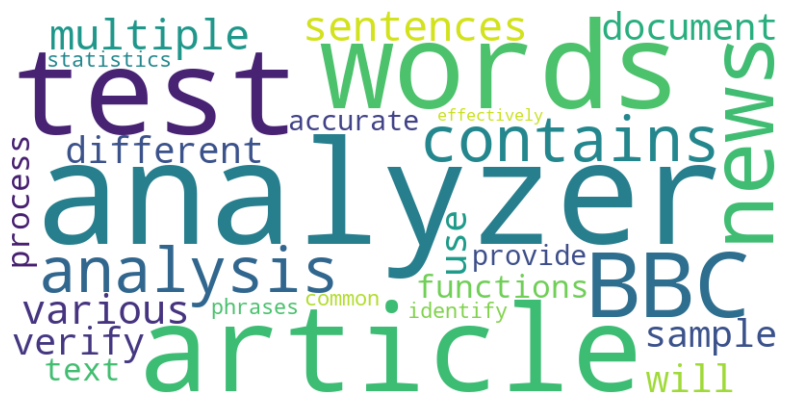

✓ Word cloud generation successful

Testing complete!

Starting main program...


Device set to use mps:0


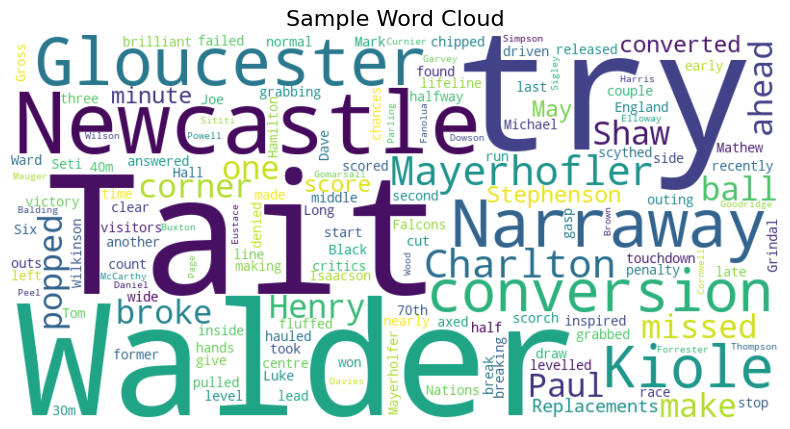

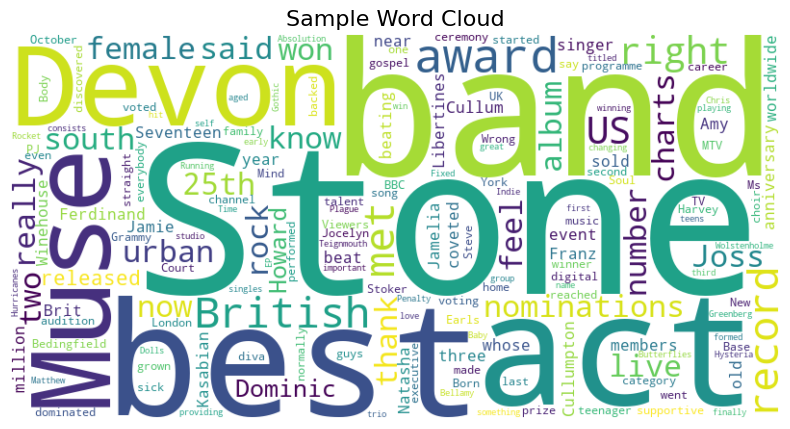

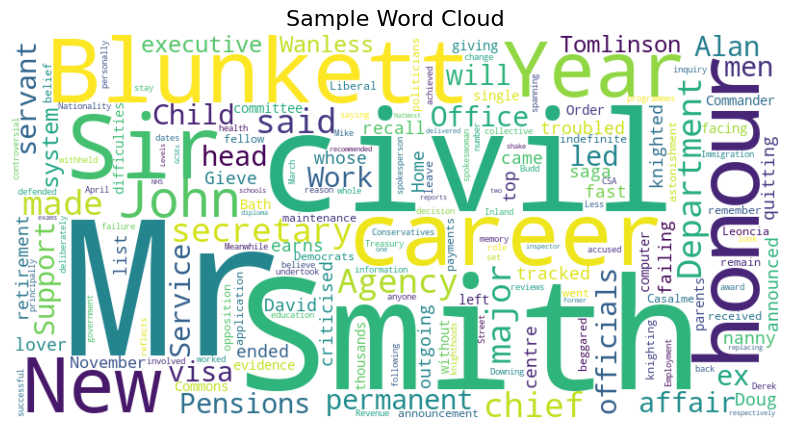

Analysis saved to: bbc_news_analysis.csv
Analysis saved to bbc_news_analysis.csv


In [22]:
if __name__ == "__main__":
    # First run tests
    print("Running the tests...")
    run_tests()
    
    # Then run main program
    print("\nStarting the main program...")
    main()